# はじめに

このノートでは、lightGBMのアルゴリズムに関して、基本的な部分をおさらいして、まとめている。下記の書籍のコードと論文を参考にしている。

- [LightGBM予測モデル実装ハンドブック](https://www.shuwasystem.co.jp/book/9784798067612.html)
- [LightGBM: A Highly Efficient Gradient Boosting Decision Tree](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)

詳細な数理についてではなく、Pythonのライブラリを利用して、アルゴリズムを理解する。

## 勾配ブースティング回帰のアルゴリズム

勾配ブースティング回帰は、回帰木を並列ではなく、直列につなぎ合わせることで、学習を進めていく。そのため、学習させ続けることで、簡単に過学習してしまう。予測値の算出に関しても、1つ回帰木の葉から予測値を得るのではなく、複数の回帰木の葉を重みづけて計算される。とはいえ、文字だけでは理解しにくいので、下記の書籍を参考にコードを書いて理解していく。

- [LightGBM予測モデル実装ハンドブック](https://www.shuwasystem.co.jp/book/9784798067612.html)

まずは深さが1のLightGBMを通じて予測値の算出過程を理解する。深さが1のLightGBMの場合、予測値は下記の通り計算される。$\eta$は学習率である。

$$
\hat{y} = \hat{y}^{(0)} + \eta w_{1}(X)
$$

イメージとしては、初期値に対して、残差をもとに計算される重みと学習率を使って予測値を算出する。

## モデルの学習

必要なライブラリをインポートしておく。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import lightgbm as lgb
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

ここで使用するデータは、ボストン市の住宅価格に関するサンプルデータ。データの説明は下記の通り。

|変数|説明|
|:---|:---|
|`CRIM`	|人口1人当たりの犯罪発生数|
|`ZN`|25,000平方フィート以上の住居区画の占める割合|
|`INDUS`|小売業以外の商業が占める面積の割合|
|`CHAS`|チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外)|
|`NOX`|NOx の濃度|
|`RM`|住居の平均部屋数|
|`AGE`|1940 年より前に建てられた物件の割合|
|`DIS`|5つのボストン市の雇用施設からの距離|
|`RAD`|高速道路へのアクセスしやすさ|
|`TAX`|$10,000 ドルあたりの不動産税率の総計|
|`PTRATIO`|町毎の児童と教師の比率|
|`B`|町毎の黒人 (Bk) の比率を次の式で表したもの。 1000(Bk – 0.63)^2|
|`LSTAT`|	給与の低い職業に従事する人口の割合 (%)|
|`MEDV`|	所有者が占有している家屋の$ 1000単位の中央値。24という表記だと24000ドル。|


In [2]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


目的変数は、所有者が占有している家屋の$1000単位の中央値`MEDV`で、24という表記だと24000ドルを意味する。特徴量は`MEDV`以外とする。また、予測値の計算過程を理解するためにデータ分割は簡単にしておく。

In [3]:
# 特徴量と目的変数の設定
# X = df.drop(['MEDV'], axis=1)
# y = df['MEDV']

# 学習データとテストデータに分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
# print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

# 特徴量と目的変数の設定
# 特徴量と目的変数の設定
X_train = df.loc[:99, ['RM']] # 特徴量に100件のRM（平均部屋数）を設定
y_train = df.loc[:99, 'MEDV'] # 正解値に100件のMEDV（住宅価格）を設定
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape)

X_trainの形状： (100, 1)  y_trainの形状： (100,)


|パラメタ名|説明|
|:---|:---|
|`objective`|	損失関数の種類|
|`metric`|	`objective`と異なる評価指標を使用する場合に利用|
|`learning_rate`|学習率。1回のブースティングで加算する重みの比率。|
|`num_leaves`|モデルが持つ葉の最大値|
|`max_depth`|決定木の深さの上限|
|`min_data_in_leaf`|葉の作成に必要な最小のサンプル数|
|`max_bin`|ヒストグラムのbinの件数の最大値|
|`min_data_in_bin`|ヒストグラムの1つのbinに含まれる最小のサンプル数|
|`n_estimators`|決定木の数|
|`verbose`|学習プロセスの詳細を表示するかどうかを制御|
|`early_stopping_rounds`|	学習を重ねても評価指標が改善しなくなった場合の停止するときの回数|

LightGBMは、特徴量をヒストグラムでビニングして分割点の計算を高速化するが、ここではその機能は無効にする。イメージとしては下記のとおり。

array([[<Axes: title={'center': 'RM'}>]], dtype=object)

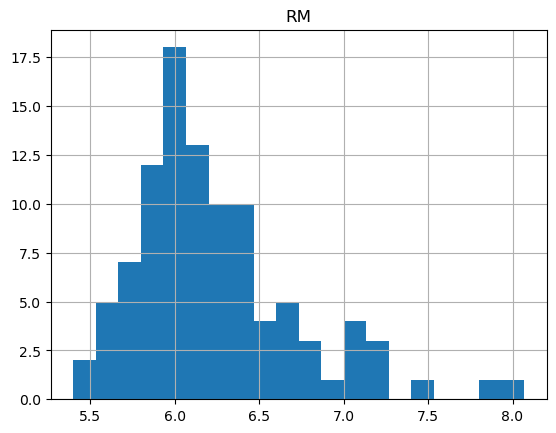

In [4]:
# max_bin=20
X_train.hist(bins=20) # 100件レコードに対してbinが20のヒストグラム

ここでは予測値の算出過程を理解するために、深さは1に設定して、モデルを学習する。

In [5]:
# ハイパーパラメータの設定
lgb_train = lgb.Dataset(X_train, y_train)

params = {
    'objective': 'mse',
    'metric': 'mse',
    'learning_rate': 0.8,
    'max_depth': 1,
    'min_data_in_leaf': 1,
    'min_data_in_bin': 1,
    'max_bin': 100,
    'seed': 0,
    'verbose': -1,
}

# モデルの学習
model = lgb.train(
  params,                            # パラメタ
  lgb_train,                         # 学習データ
  num_boost_round=1,                # ブースティング回数
  valid_sets=[lgb_train],            # 誤差の計算に使用する学習データ
  valid_names=['train'],             # ログの表示ラベル
  callbacks=[lgb.log_evaluation(5)]  # 評価過程を表示。学習データの予測値と正解値の誤差が一致している。
)

学習データの予測と評価しておく。今回の設定であれば、`l2`は`MSE`なので、学習データの予測値と正解値の誤差が一致する。

In [6]:
# 学習データの予測と評価
y_train_pred = model.predict(X_train)
print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
# print('RMSE train: %.2f' % (mean_squared_error(y_train, y_train_pred) ** 0.5))
# print('------------------------------------------')
# テストデータの予測と評価
# y_test_pred = model.predict(X_test)
# print('MSE test: %.2f' % (mean_squared_error(y_test, y_test_pred)))
# print('RMSE test: %.2f' % (mean_squared_error(y_test, y_test_pred) ** 0.5))


MSE train: 17.10


決定木の深さが1なので、予測値は2種類しか存在しない。ここでの目的どおり、予測値21.04がどのように計算されたのかを理解していく。

In [7]:
list(set(y_train_pred))

[21.040890996699986, 31.608467316627504]

ブースティングしている決定木は1つなので、可視化できる木は1つのみ。これをみると、`RM<=6.793`で分割されていることがわかる。

<Axes: >

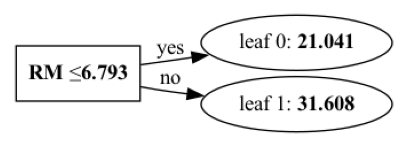

In [14]:
# 1本目の木の可視化
lgb.plot_tree(model, tree_index=0, figsize=(5, 5))

`RM<=6.793`で分割されていることを理解するためには、可視化してみるとわかりよい。しきい値でデータを分割し、葉を左右で分けている。

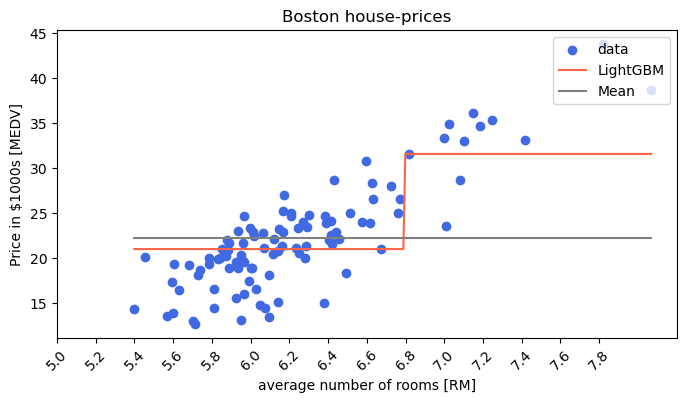

In [9]:
# データと予測値の可視化
plt.figure(figsize=(8, 4)) #プロットのサイズ指定
X = X_train.values.flatten() # numpy配列に変換し、1次元配列に変換
y = y_train.values # numpy配列に変換

# Xの最小値から最大値まで0.01刻みのX_pltを作成し、2次元配列に変換
X_plt = np.arange(X.min(), X.max(), 0.01)[:, np.newaxis]
y_pred = model.predict(X_plt) # 住宅価格を予測

# 学習データ(平均部屋数と住宅価格)の散布図と予測値のプロット
plt.scatter(X, y, color='royalblue', label='data')
plt.plot(X_plt, y_pred, color='tomato', label='LightGBM')
plt.plot(X_plt, np.full_like(X_plt, np.mean(y)), color='gray', label='Mean') # 平均ラインをプロット
plt.ylabel('Price in $1000s [MEDV]')
plt.xlabel('average number of rooms [RM]')
plt.title('Boston house-prices')
plt.legend(loc='upper right')
# x軸の目盛りを0.1刻みに設定
plt.xticks(np.arange(5, 8, 0.2), rotation=45)


plt.show()

## 予測値の計算過程

深さ1の場合、予測値は下記の通り計算される。

$$
\hat{y} = \hat{y}^{(0)} + \eta w_{1}(X)
$$

$\hat{y}^{(0)}$はデータの平均値から計算される。　


In [10]:
# 初期値
print('samples:', len(y)) # レコード数
pred0 = sum(y)/len(y) # 予測値（平均）
print('pred0:', pred0)

samples: 100
pred0: 22.30900000000001


100件のデータは`RM<=6.793`で分割されるため、これを再現する。まずは左のリーフを考える。

In [11]:
# 左葉のレコード
threshold = 6.793 # 左右に分割する分割点
X_left = X[X<=threshold] # 左葉の特徴量
y_left = y[X<=threshold] # 左葉の正解値
print('X_left:', X_left)
print('----------------------------------------------------------------------------------------')
print('y_left:', y_left)


X_left: [6.575 6.421 6.43  6.012 6.172 5.631 6.004 6.377 6.009 5.889 5.949 6.096
 5.834 5.935 5.99  5.456 5.727 5.57  5.965 6.142 5.813 5.924 5.599 5.813
 6.047 6.495 6.674 5.713 6.072 5.95  5.701 6.096 5.933 5.841 5.85  5.966
 6.595 6.77  6.169 6.211 6.069 5.682 5.786 6.03  5.399 5.602 5.963 6.115
 6.511 5.998 5.888 6.383 6.145 5.927 5.741 5.966 6.456 6.762 6.29  5.787
 5.878 5.594 5.885 6.417 5.961 6.065 6.245 6.273 6.286 6.279 6.14  6.232
 5.874 6.727 6.619 6.302 6.167 6.389 6.63  6.015 6.121 6.417 6.405 6.442
 6.211 6.249 6.625 6.163]
----------------------------------------------------------------------------------------
y_left: [24.  21.6 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4 18.2 19.9 23.1
 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8 18.4 21.  12.7
 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 26.6 25.3 24.7 21.2 19.3
 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 24.7 23.3 19.6 18.7 16.
 22.2 25.  23.5 19.4 22.  17.4 20.9 24.2 21.7 22.8 23.4 24.1 21.4 20.
 20.8

最初の残差は、目的変数と初期値の差分になる。重みは`mse`を指定したため、残差の平均値になる。そのため、まずは残差を計算し、残差の平均値を求める。そして、学習率を重みにかけて、初期値と足し合わせる。そうすることで、予測値の21.04が得られる。

In [12]:
# 左葉の予測値
print('samples_left:', len(y_left)) # 左葉のレコード数
residual_left = y_left - pred0 # 残差
weight_left = sum(residual_left)/len(y_left) # 重み
print('weight_left:', weight_left)
y_pred_left = pred0 + 0.8 * weight_left # 左葉の予測値
print('y_pred_left:', y_pred_left)

samples_left: 88
weight_left: -1.5851363636363767
y_pred_left: 21.040890909090912


右葉の予測値も同じように計算すれば、予測値31.60が得られる。

In [13]:
# 右葉のレコード
X_right = X[threshold<X] # 右葉の特徴量
y_right = y[threshold<X] # 右葉の正解値
print('X_right:', X_right)
print('y_right:', y_right)
# 右葉の予測値
print('samples_right:', len(y_right)) # 右葉のレコード数
residual_right = y_right - pred0 # 残差
weight_right = sum(residual_right)/len(y_right) # 重み
print('weight_right:', weight_right)
y_pred_right = pred0 + 0.8 * weight_right # 右葉の予測値
print('y_pred_right:', y_pred_right)

X_right: [7.185 6.998 7.147 7.024 7.249 6.816 7.104 7.007 7.079 8.069 7.82  7.416]
y_right: [34.7 33.4 36.2 34.9 35.4 31.6 33.  23.6 28.7 38.7 43.8 33.2]
samples_right: 12
weight_right: 11.624333333333324
y_pred_right: 31.608466666666672
